In [6]:
pip install xgboost transformers

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import os
import csv
import librosa
import librosa.display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch

# Initialize scaler and encoder
scaler = StandardScaler()
le = LabelEncoder()


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 no

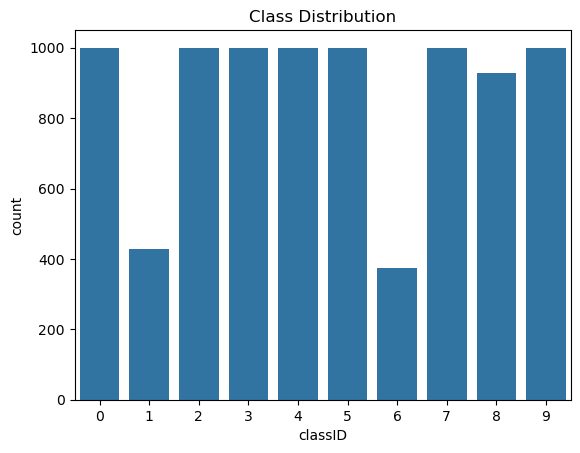

In [10]:
df = pd.read_csv('urbansound8k/metadata/UrbanSound8K.csv')
print(df.head())
print(df.info())
sns.countplot(x=df['classID'])
plt.title('Class Distribution')
plt.show()


#### Loading Audio Files

In [11]:
audio_files = []
labels = []

label_dict = {}
with open("urbansound8k/metadata/UrbanSound8K.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        label_dict[row[0]] = row[7]

for fold in range(1, 11):  # UrbanSound8K contains data in 10 folds   relative path ---> UrbanSound8K/audio
    fold_path = f"UrbanSound8K/audio/fold{fold}/"
    for filename in os.listdir(fold_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(fold_path, filename)
            data, sr = librosa.load(file_path, sr=None)
            audio_files.append((data, sr))
            labels.append(label_dict[filename])


#### Visualizing Audio (Waveform and Spectograms) 

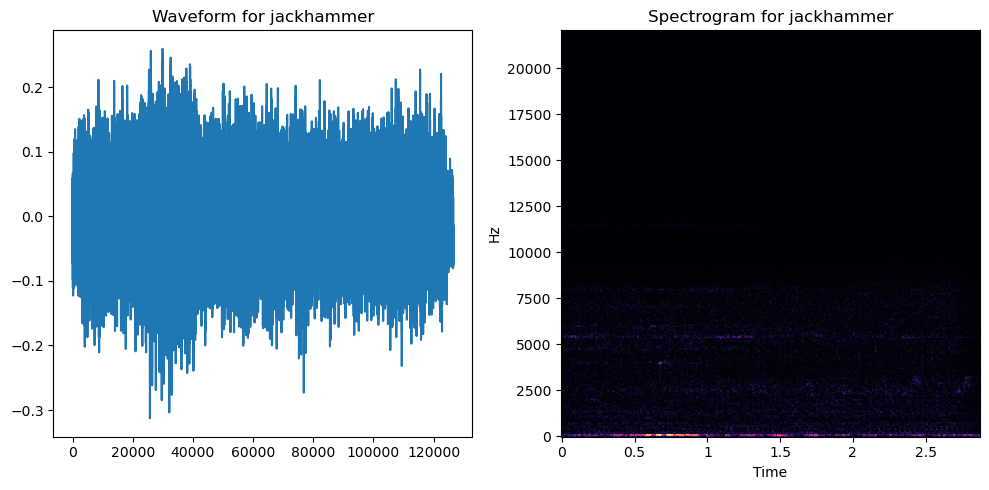

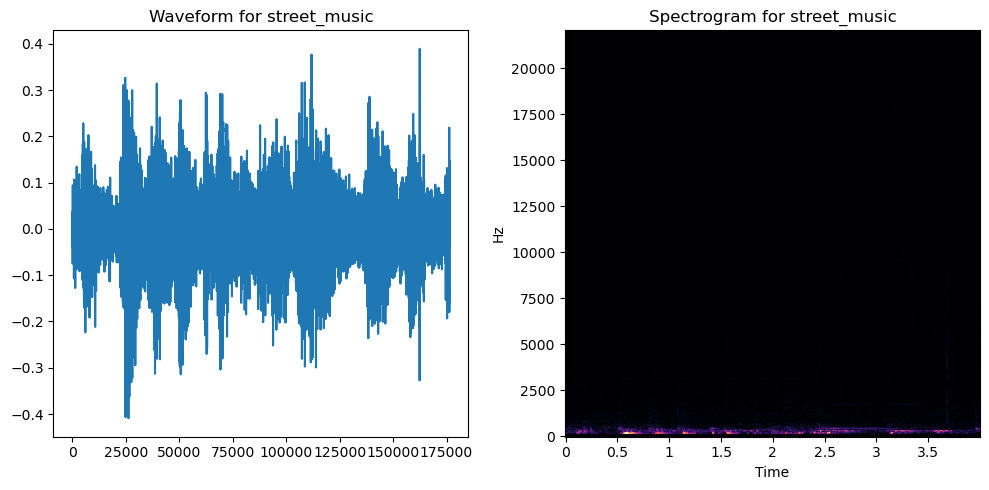

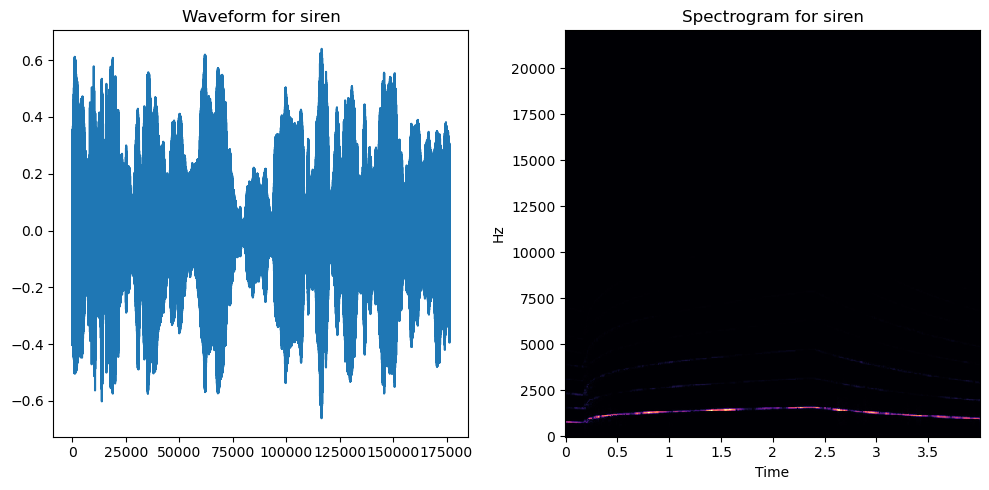

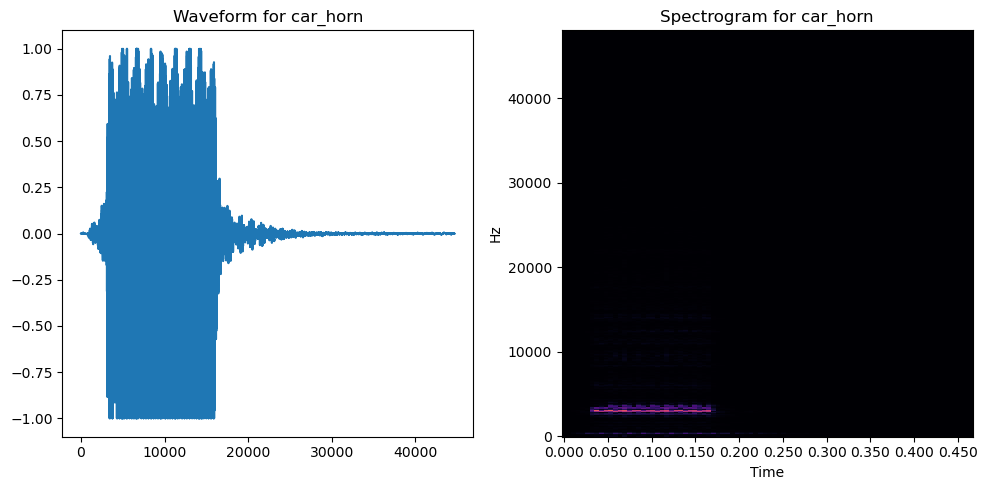

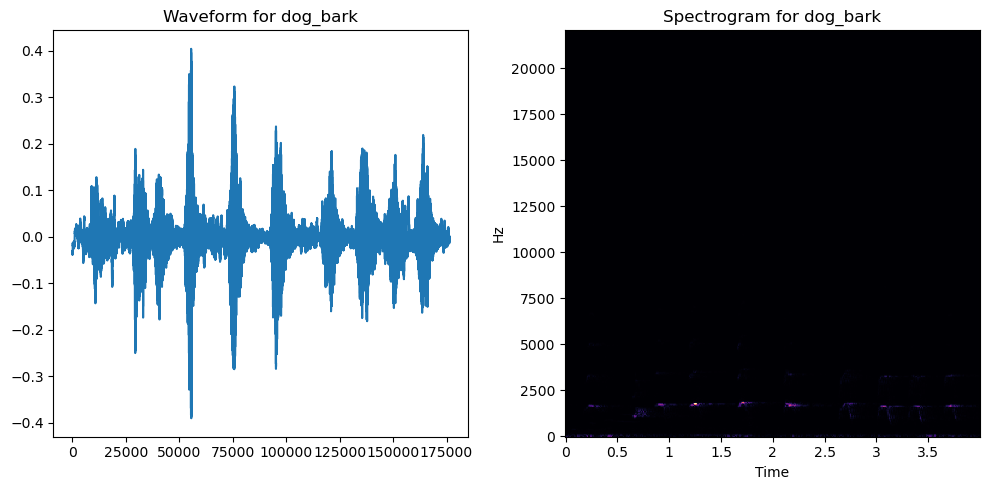

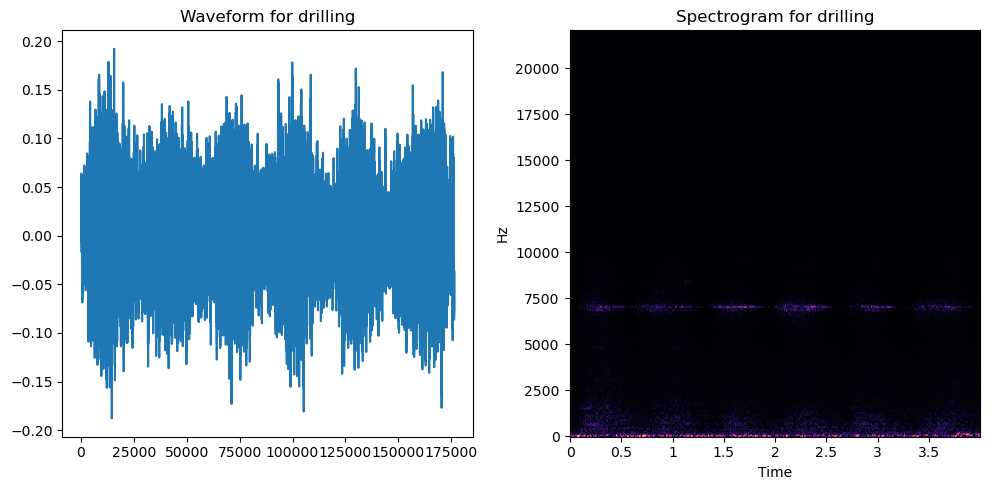

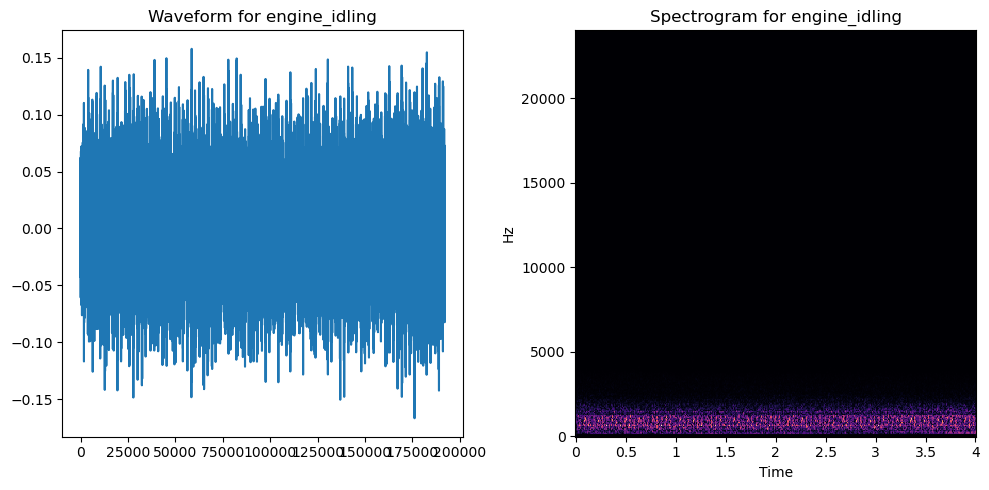

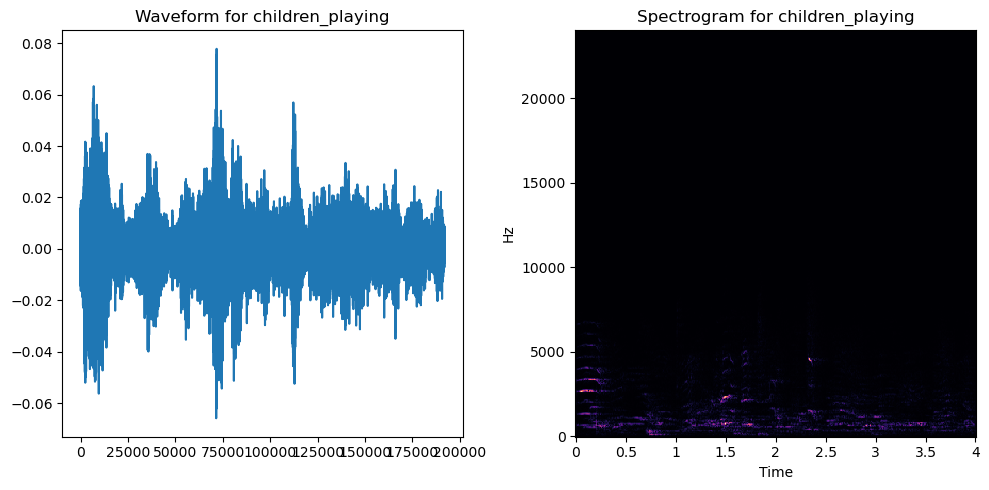

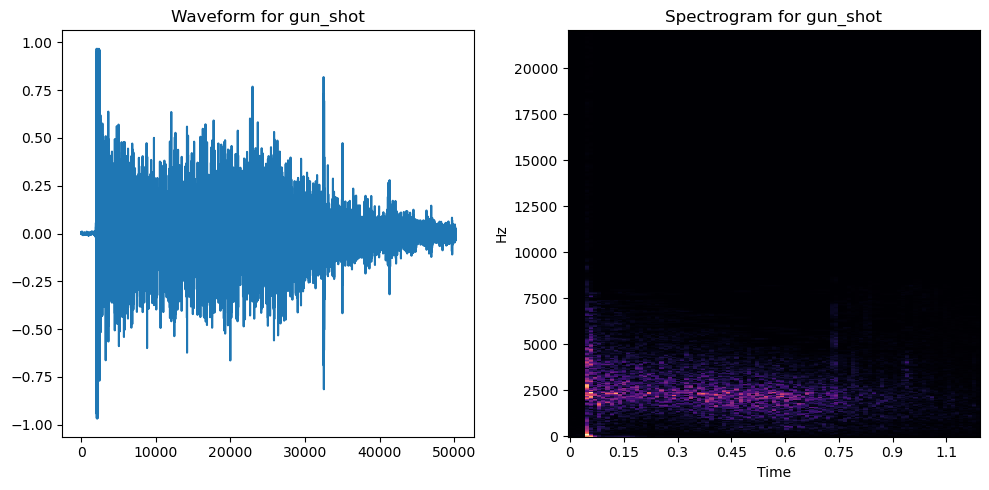

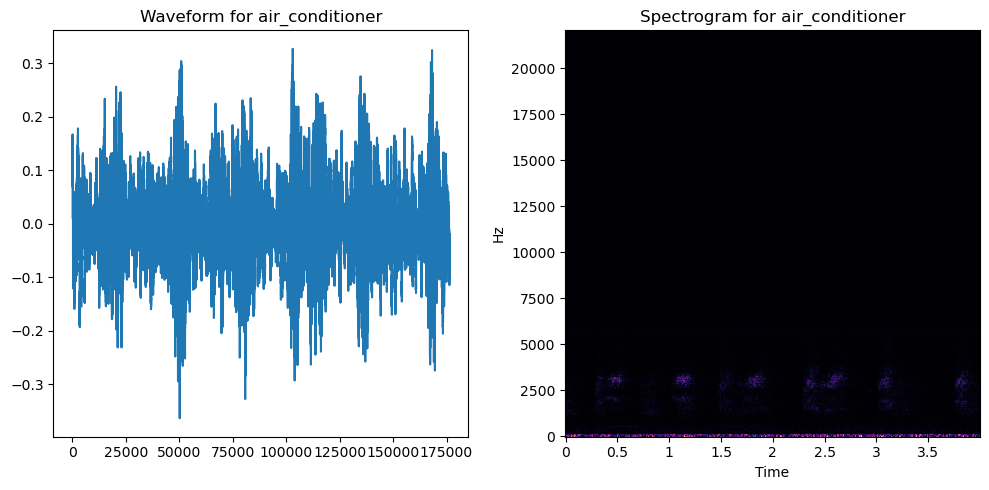

In [14]:
for category in set(labels):
    index = labels.index(category)
    data, sr = audio_files[index]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax1.plot(data)
    ax1.set_title(f"Waveform for {category}")
    S = librosa.stft(data, n_fft=1024, hop_length=512)
    spectrogram = np.abs(S)
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear', ax=ax2)
    ax2.set_title(f"Spectrogram for {category}")
    plt.tight_layout()
    plt.show()


#### Feature Extraction (using MFCC)

In [15]:
X = []
for data, sr in audio_files:
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    X.append(mfccs_scaled)

X = scaler.fit_transform(X)
y = le.fit_transform(labels)


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


#### Splitting Data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Training and Evaluation

In [19]:
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier(),
    MLPClassifier(max_iter=300),  # Increase iterations to avoid convergence issues
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Required for XGBoost
]

results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall'])

# List of classifiers
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier(),
    MLPClassifier(max_iter=300),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')
]

# DataFrame to store results
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall'])

# Loop through classifiers and compute metrics
for clf in classifiers:
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    # Append results to DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Classifier': [clf.__class__.__name__],
        'Accuracy': [accuracy * 100],  # Convert to percentage
        'Precision': [precision * 100],
        'Recall': [recall * 100]
    })], ignore_index=True)

# Sort results by Accuracy
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Display the results
from IPython.display import display
display(results)


/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Classifier,Accuracy,Precision,Recall
7,XGBClassifier,90.097310,90.696887,88.922086
2,RandomForestClassifier,89.639382,91.291343,87.747162
0,KNeighborsClassifier,88.036634,88.535161,87.292217
6,MLPClassifier,87.406983,88.101102,87.108376
4,GradientBoostingClassifier,80.995993,82.468859,79.779925
1,DecisionTreeClassifier,69.147109,68.131359,68.035459
5,SGDClassifier,52.718947,51.598587,50.852382
3,AdaBoostClassifier,40.297653,40.163358,41.739581


#### Metrics to compare the results

## Using Wave2Vec Embeddings

In [29]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.

In [30]:
TARGET_SR = 16000  # Target sampling rate
embeddings = []

for data, sr in audio_files:
    # Resample to 16000 Hz
    if sr != TARGET_SR:
        data = librosa.resample(data, orig_sr=sr, target_sr=TARGET_SR)
        sr = TARGET_SR

    # Preprocess audio
    inputs = processor(data, sampling_rate=sr, return_tensors="pt", padding=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state  # Shape: [batch_size, sequence_length, hidden_size]
        
        # Aggregate embeddings (e.g., mean over sequence dimension)
        embeddings.append(last_hidden_states.mean(dim=1).squeeze().numpy())

# Convert to NumPy array
X_embeddings = np.array(embeddings)


In [31]:
# Scale the embeddings
scaler = StandardScaler()
X_embeddings_scaled = scaler.fit_transform(X_embeddings)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier(),
    MLPClassifier(max_iter=300),  # Increase max iterations to avoid convergence issues
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # XGBoost requires eval_metric
]

# DataFrame to store results
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall'])


In [35]:
y_test[0:200]

array([9, 8, 5, 4, 2, 9, 3, 9, 5, 3, 4, 7, 3, 3, 8, 0, 8, 8, 4, 6, 4, 2,
       3, 5, 3, 1, 0, 5, 4, 7, 6, 5, 9, 1, 7, 4, 3, 4, 2, 9, 3, 9, 0, 0,
       2, 7, 9, 1, 9, 7, 4, 8, 9, 0, 8, 7, 8, 9, 8, 5, 7, 3, 0, 7, 2, 4,
       3, 7, 7, 2, 2, 4, 5, 4, 2, 5, 8, 8, 5, 7, 3, 8, 0, 7, 4, 4, 9, 5,
       8, 7, 3, 3, 6, 8, 8, 2, 5, 9, 2, 3, 8, 7, 5, 3, 9, 2, 8, 5, 4, 5,
       9, 0, 9, 0, 8, 8, 8, 2, 8, 1, 4, 0, 1, 2, 7, 0, 5, 8, 6, 0, 9, 2,
       0, 5, 7, 7, 4, 8, 9, 0, 3, 5, 1, 0, 3, 1, 1, 3, 2, 9, 6, 5, 6, 4,
       5, 3, 9, 2, 5, 8, 9, 1, 1, 8, 3, 8, 2, 3, 8, 1, 9, 3, 9, 1, 2, 9,
       5, 4, 4, 5, 0, 8, 2, 4, 2, 8, 5, 4, 0, 4, 0, 2, 7, 6, 4, 9, 7, 5,
       6, 9])

In [32]:
# Train classifiers and evaluate
for clf in classifiers:
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = clf.predict(X_test)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    # Append results
    results = pd.concat([results, pd.DataFrame({
        'Classifier': [clf.__class__.__name__],
        'Accuracy': [accuracy * 100],
        'Precision': [precision * 100],
        'Recall': [recall * 100]
    })], ignore_index=True)

# Sort by accuracy
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Display the results
from IPython.display import display
display(results)

/Users/guneeshvats/miniconda3/envs/adalat_v3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [18:43:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Classifier,Accuracy,Precision,Recall
6,MLPClassifier,76.817401,76.988950,76.278934
7,XGBClassifier,73.325701,74.737083,72.405966
2,RandomForestClassifier,67.830567,69.978907,66.794056
0,KNeighborsClassifier,67.429880,70.309213,67.352268
5,SGDClassifier,67.315398,70.274456,67.254525
4,GradientBoostingClassifier,64.796795,66.434941,64.332101
1,DecisionTreeClassifier,46.651402,46.305037,46.358933
3,AdaBoostClassifier,34.459073,37.307939,35.413271
